In [1]:
import numpy as np
import pandas as pd

# import tensorflow as tf

# from utils.utils import *
# from utils.Atc_code import *
# from utils.utils_baseline_svm import *

# from utils.kwargs_file import kwargs_lin_data_init, kwargs_svm

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

%matplotlib inline

# import csv

# from sklearn.feature_extraction import DictVectorizer
# from sklearn import svm

# from collections import Counter, OrderedDict
# from itertools import combinations

# from math import inf
# from time import time

In [2]:
figure_dir = 'figures/'

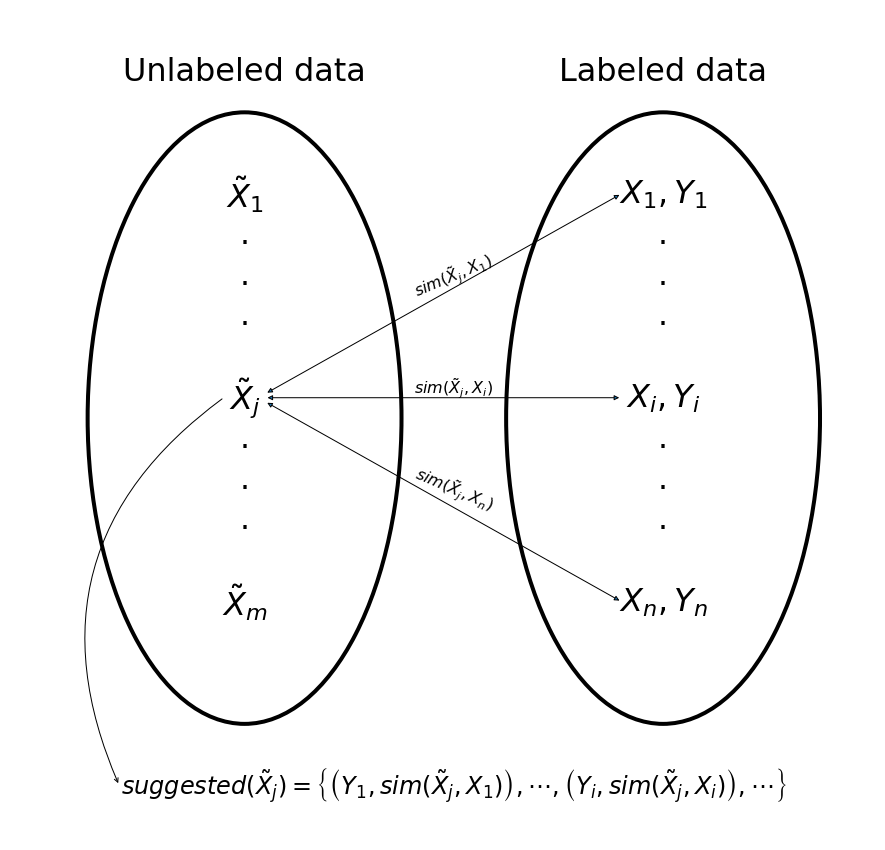

In [3]:
# If only one location is given, the text and xypoint being
# annotated are assumed to be the same

fig_height = 15
fig_width = 15
fig = plt.figure(figsize=(fig_width, fig_height))  # width, height

el_height = 30
el_width = 15

el1 = Ellipse((-10, 0), el_width, el_height, 
             facecolor='none',
             edgecolor='black',
             linewidth=4,
             alpha=1)

el2 = Ellipse((10, 0), el_width, el_height, 
             facecolor='none',
             edgecolor='black',
             linewidth=4,
             alpha=1)

ax = fig.add_subplot(111) 

ax.add_artist(el1)
ax.add_artist(el2)
# el1.set_clip_box(ax.bbox)

fontsize_set = 32
fontsize = 32

# plot a dot
plot_dot = lambda x, dist: \
    ax.annotate('.', xy=(x, el_height / 2 - dist),
                ha='center', va='center',
                fontsize=fontsize)

## unlabeled data ellipse
ax.annotate('Unlabeled data', xy=(-10, el_height / 2 + 2),
            ha='center', va='center',
            fontsize=fontsize_set)

## plot x, ..., x, ..., x
ax.annotate(r'$\tilde{X}_1$', xy=(-10, el_height / 2 - 4),
            ha='center', va='center',
            fontsize=fontsize)
# plot 3 dot, horizontally
[plot_dot(-10, _) for _ in [6, 8, 10]]
ax.annotate(r'$\tilde{X}_j$', xy=(-10, el_height / 2 - 14),
            ha='center', va='center',
            fontsize=fontsize)
# plot 3 dot, horizontally
[plot_dot(-10, _) for _ in [16, 18, 20]]
ax.annotate(r'$\tilde{X}_m$', xy=(-10, el_height / 2 - 24),
            ha='center', va='center',
            fontsize=fontsize)


## labeled data ellipse
ax.annotate('Labeled data', xy=(10, el_height / 2 + 2),
            ha='center', va='center',
            fontsize=fontsize_set)

## plot x, ..., x, ..., x
ax.annotate(r'$X_1, Y_1$', xy=(10, el_height / 2 - 4),
            ha='center', va='center',
            fontsize=fontsize)
# plot 3 dot, horizontally
[plot_dot(10, _) for _ in [6, 8, 10]]
ax.annotate(r'$X_i, Y_i$', xy=(10, el_height / 2 - 14),
            ha='center', va='center',
            fontsize=fontsize)
# plot 3 dot, horizontally
[plot_dot(10, _) for _ in [16, 18, 20]]
ax.annotate(r'$X_n, Y_n$', xy=(10, el_height / 2 - 24),
            ha='center', va='center',
            fontsize=fontsize)

# arrows from ~X_j
ax.annotate('',
            xy=(-10 + 1, 0.2 + el_height / 2 - 14),
            xytext=(10 - 2, el_height / 2 - 4),
            arrowprops=dict(arrowstyle='<|-|>'))
ax.annotate('',
            xy=(-10 + 1, 0.0 + el_height / 2 - 14),
            xytext=(10 - 2, el_height / 2 - 14),
            arrowprops=dict(arrowstyle='<|-|>'))
ax.annotate('',
            xy=(-10 + 1, - 0.2 + el_height / 2 - 14),
            xytext=(10 - 2, el_height / 2 - 24),
            arrowprops=dict(arrowstyle='<|-|>'))

## similarity text
ax.annotate(r'$sim(\tilde{X}_j, X_1)$', xy=(0, 7),
            ha='center', va='center',
            fontsize=fontsize*0.5, 
            rotation=23)

ax.annotate(r'$sim(\tilde{X}_j, X_i)$', xy=(0, 1.5),
            ha='center', va='center',
            fontsize=fontsize*0.5)

ax.annotate(r'$sim(\tilde{X}_j, X_n)$', xy=(0, -3.5),
            ha='center', va='center',
            fontsize=fontsize*0.5, 
            rotation=-23)

sim_eq = r'$suggested(\tilde{X}_j) = \left \{ \left( Y_1, sim(\tilde{X}_j, X_1) \right),\cdots ,\left( Y_i, sim(\tilde{X}_j, X_i) \right),\cdots\right \}$'
ax.annotate(sim_eq, xy=(0, -18),
            ha='center', va='center',
            fontsize=fontsize*0.75)

ax.annotate('',
            xy=(-16, -18), xycoords='data',
            xytext=(-10 - 1, el_height / 2 - 14), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=.4"))

ax.set_xlim([-20, 20])
ax.set_ylim([-20, 20])

ax.axis('off')

# plt.show()

plt.savefig(figure_dir + 'foo.pdf', bbox_inches='tight')

# text and math examples
# https://matplotlib.org/users/text_intro.html
# https://matplotlib.org/users/mathtext.html
# http://matplotlib.org/examples/pylab_examples/tex_unicode_demo.html

# plotting examples
# http://matplotlib.org/examples/pylab_examples/annotation_demo.html
# https://matplotlib.org/users/annotations_guide.html
# http://matplotlib.org/examples/pylab_examples/annotation_demo3.html
